In [1]:
import numpy as np
import cv2
from IPython.display import Image

## Задача

Прочитать изображение из файла.

Преобразовать изображение в YUV. Далее для Y – канала выполнить шаги 3-8.

Улучшить контраст (equalizeHist).

Найти края объектов (Canny).

Найти угловые точки на изображении. Нарисовать их кругом с радиусом r (r=2) в тоже изображение где края.

Для найденных границ и угловых точек строится карта расстояний D[i,j] методом distance transform.

В каждом пикселе [i,j] производится фильтрация усреднением.

Размер фильтра для усреднения зависит от расстояния до угловых и краевых точек и равен k*D[i,j], где к – параметр алгоритма. Таким образом, чем дальше от края или угла, тем больше усреднение (большее подавление шума).

Для ускорения вычислений при усреднении нужно использовать интегральные изображения.

Сделать обратное преобразование YUV->BGR. Отобразить BGR.

## Решение

In [2]:
# 1. Read image
brg_image = cv2.imread('whiteballssample.jpg', cv2.IMREAD_COLOR)

# 2. Convert from BGR to YUV
yuv_image = cv2.cvtColor(brg_image, cv2.COLOR_BGR2YUV)
y_image = yuv_image[:,:,0]

# 3. Improve contrast
y_image = cv2.equalizeHist(y_image)

# 4. Search for object edges
edges = cv2.Canny(y_image, 96, 192)

# 5. Search for corners
block_size = 4
aperture_size = 5
k = 0.05
corners = cv2.cornerHarris(y_image, block_size, aperture_size, k)
corners_norm = np.empty(corners.shape, dtype=np.float32)
cv2.normalize(corners, corners_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
corners_norm_scaled = cv2.convertScaleAbs(corners_norm)

# 6. Build distances map
distances = cv2.distanceTransform(edges, cv2.DIST_L2, 5, cv2.DIST_LABEL_CCOMP)

# 7-8. Filter by averaging
integral_map = cv2.integral(y_image)

avg_y_image = y_image.copy()
for iR in range(y_image.shape[0]):
    for iC in range(y_image.shape[1]):
        filter_size = max([2, int(k * distances[iR][iC])])
        if filter_size % 2 == 0:
            filter_size -= 1

        up = max([iR - filter_size // 2, 0])
        down = min([iR + filter_size // 2, y_image.shape[0] - 1])
        left = max([iC - filter_size // 2, 0])
        right = min([iC + filter_size // 2, y_image.shape[1] - 1])

        filter_square = (down - up + 1) * (right - left + 1)
        filter_value = integral_map[down + 1][right + 1] + integral_map[up][left] - (integral_map[up][right + 1] + integral_map[down + 1][left])
        avg_y_image[iR][iC] = filter_value / filter_square

yuv_image[:,:,0] = avg_y_image
y_image = yuv_image[:,:,0]

corner_threshold = 200
for iR in range(y_image.shape[0]):
    for iC in range(y_image.shape[1]):
        if corners_norm_scaled[iR][iC] > corner_threshold:
            yuv_image = cv2.circle(yuv_image, [iC, iR], 4, [81, 90, 240])

## Полученное изображение

Отметки углов видны на цифрах шаров и на стыке левой пары

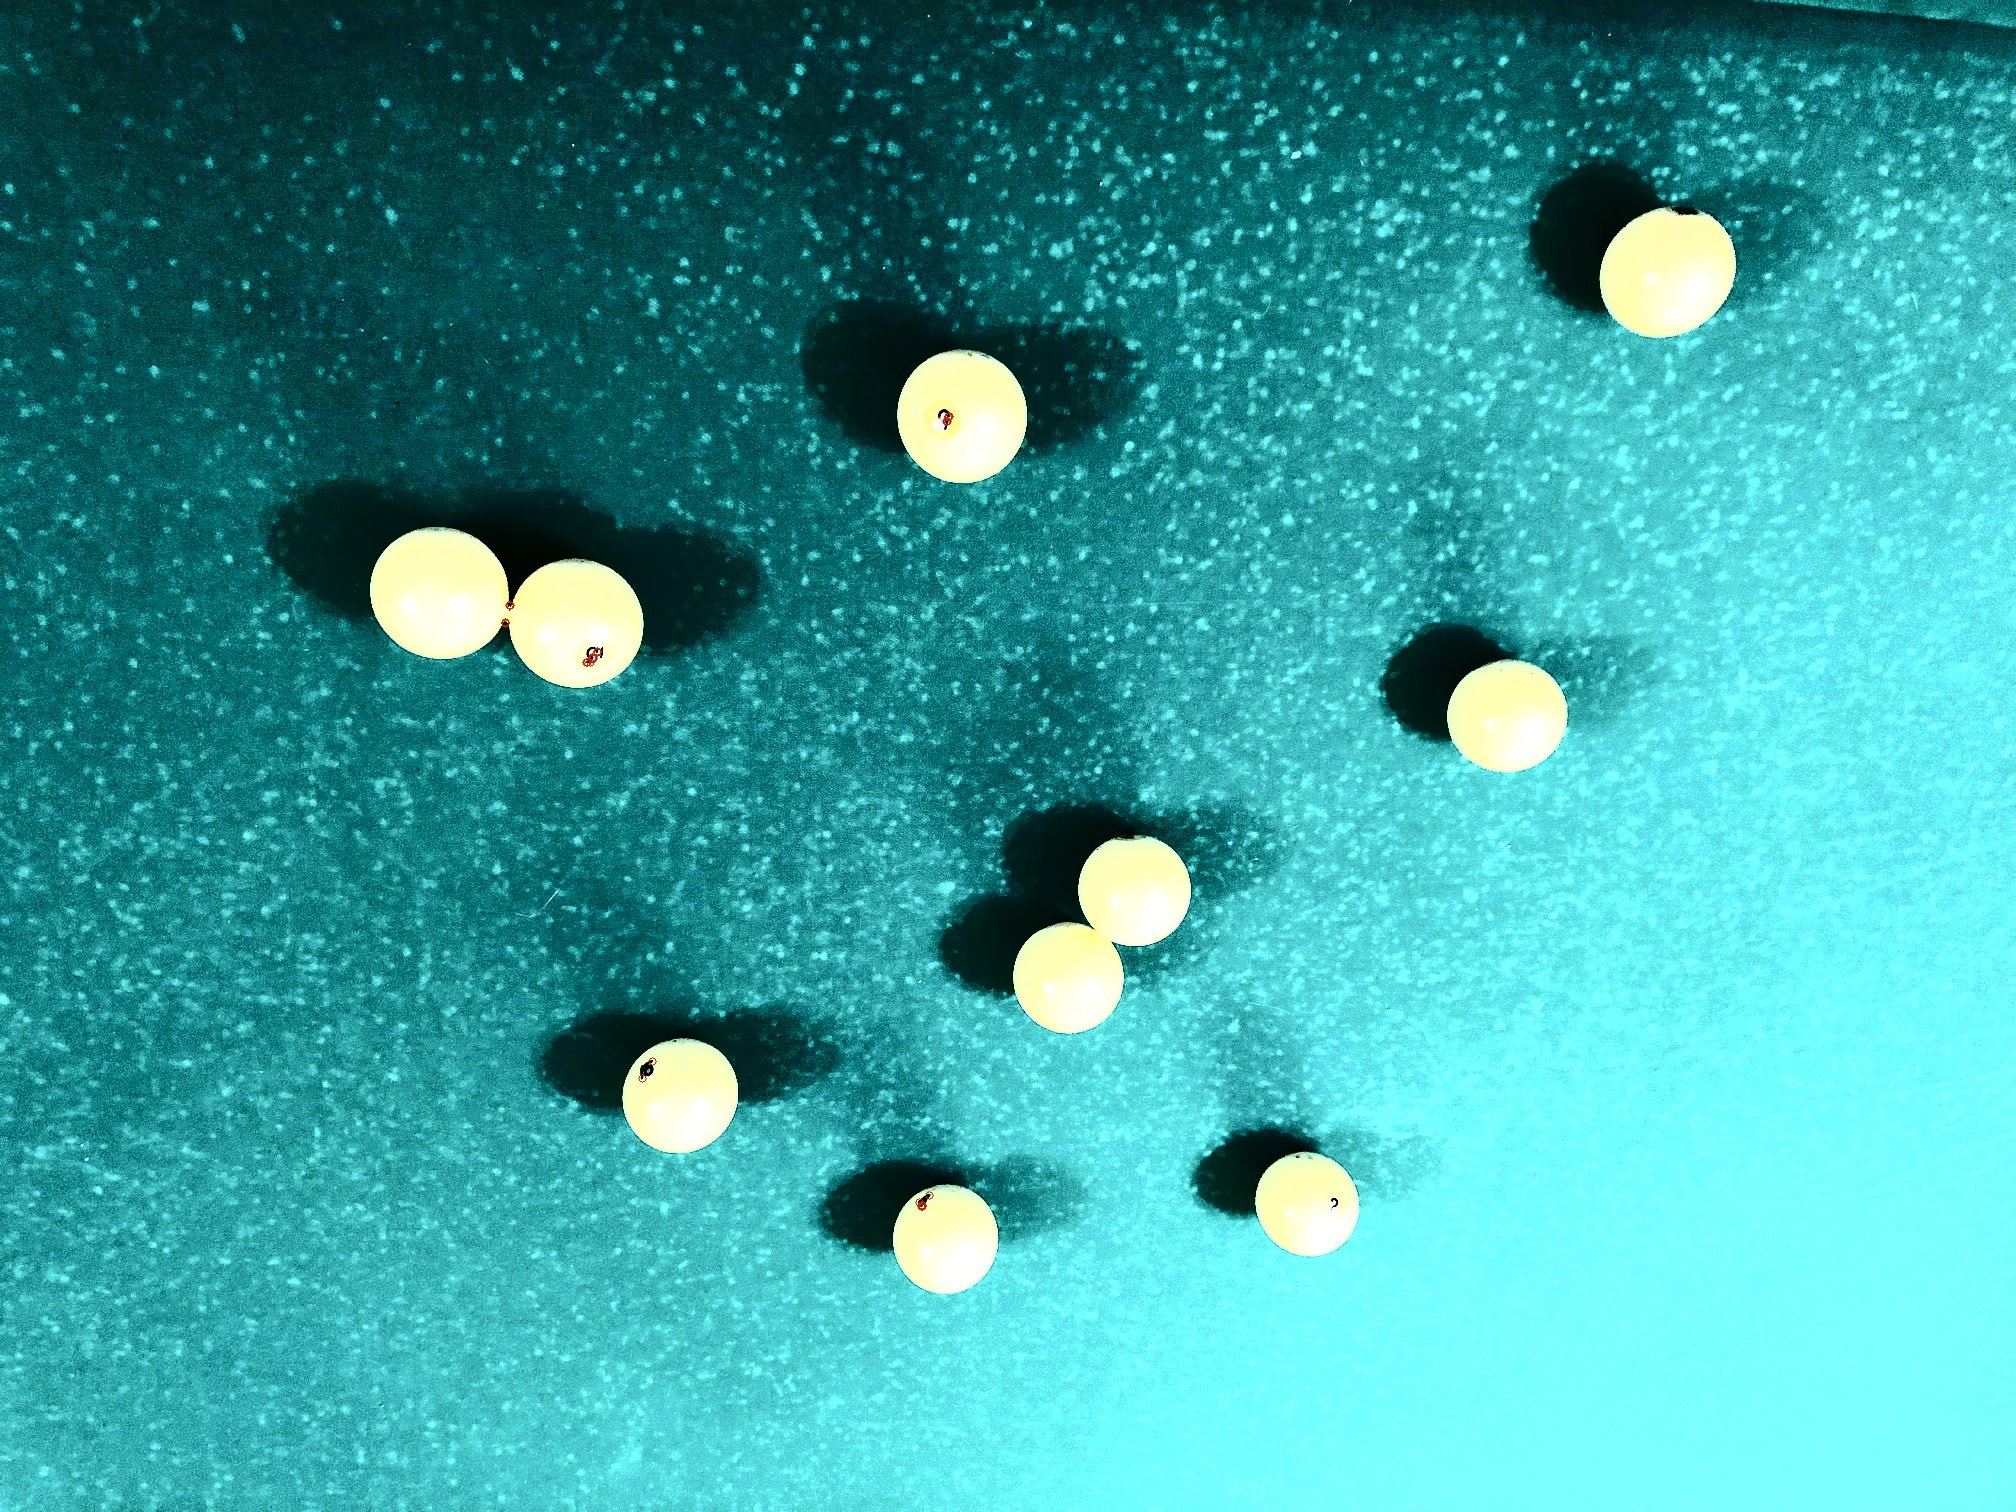

In [3]:
brg_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)
result_image_name = 'whiteballssample_task2.jpg'
cv2.imwrite(result_image_name, brg_image)
Image(result_image_name)